<a href="https://colab.research.google.com/github/lazy-wolf/Sample/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
#Input Layer
input_img = Input(shape=(32, 32, 3))
#Encoding Layer
x = Reshape((32*32*3,))(input_img)
x = Dense(32, activation='relu')(x)
encoded = Dense(16, activation='relu')(x)
#Decoding Layer
x = Dense(32, activation='relu')(encoded)
x = Dense(32*32*3, activation='sigmoid')(x)
decoded = Reshape((32, 32, 3))(x)
#AutoEncoder Model
autoencoder = Model(input_img, decoded)

In [ ]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss='mse')
autoencoder.summary()

In [ ]:
#Early Stopping with Patience as 5
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
file_path = 'best_model.h5'
#Saving Best Model
model_check = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#Training the AutoEncoder Model
history = autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=25, batch_size=32, callbacks=[early_stop, model_check], verbose=0)

In [ ]:
history.history.keys()

In [ ]:
plt.figure(figsize=(12,7))

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
results=autoencoder.evaluate(x_test, x_test)
results

In [ ]:
x_test_pred = autoencoder.predict(x_test)

In [6]:
def calculate_reconstruction_losses(original, reconstructed):
    mse_loss = tf.keras.losses.mean_squared_error(original.flatten(), reconstructed.flatten()).numpy()
    bce_loss = tf.keras.losses.binary_crossentropy(original.flatten(), reconstructed.flatten()).numpy()
    return mse_loss, bce_loss

In [ ]:
calculate_reconstruction_losses(x_test, x_test_pred)

In [ ]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test[i]
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_test_pred[i]
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

In [ ]:
def hyperparameter_tuning_strategy(cofig, x_train, x_test):
  learning_rate, latent_space_dim = config
  possible_combinations = list(itertools.product(learning_rate, latent_space_dim))
  print("*"*25)
  print(f"Possible No.of Combinations : {possible_combinations}")
  print("*"*25)
  hist = []
  for i in range(len(possible_combinations)):
    print("*"*25)
    print(f"Combination : {i+1}")
    print("*"*25)
    l_r, latent_dim = possible_combinations[i]
    #Input Layer
    input_img = Input(shape=(32, 32, 3))
    #Encoding Layer
    x = Reshape((32*32*3,))(input_img)
    x = Dense(32, activation='relu')(x)
    encoded = Dense(latent_dim, activation='relu')(x)
    #Decoding Layer
    x = Dense(32, activation='relu')(encoded)
    x = Dense(32*32*3, activation='sigmoid')(x)
    decoded = Reshape((32, 32, 3))(x)
    #AutoEncoder Model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r), loss='mse')
    #Early Stopping with Patience as 5
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    file_path = 'best_model.h5'
    #Saving Best Model
    model_check = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    #Training the AutoEncoder Model
    history = autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=25, batch_size=32, callbacks=[early_stop, model_check], verbose=0)
    test_loss = autoencoder.evaluate(x_test, x_test)
    hist.append(list((l_r, latent_dim, test_loss)))
    print(f"Combination : {i+1} -> {possible_combinations[i]} test_mse : {test_loss}")
    print("*"*25)
    print("*"*25)
  return hist


In [ ]:
config = [[0.01, 0.02], [8, 16]]

hist = hyperparameter_tuning_strategy(config, x_train, x_test)

In [ ]:
hist = pd.DataFrame(hist, columns=["Learning Rate", "Latent Dimension Space","Test Loss"])
hist = hist.sort_values(by=["Test Loss"], ascending=True)
hist

In [ ]:
print("*"*25)
print(f"----Best Combination---- \n Learning Rate = {hist.iloc[0,0]}\n Latent Dimension Space = {hist.iloc[0,1]}\n")
print("*"*25)
print("*"*25)
before_mse = np.round(results, 4)
after_mse = np.round(hist.iloc[0, 2], 4)
print(f'Results Before Tunning:\n Test Loss MSE: {before_mse}\n')
print(f'Results After Tunning:\n Test Loss MSE: {after_mse}\n')
print(f'{np.round((before_mse-after_mse)*100/before_mse)}% Improvement')

In [ ]:
l_r, latent_dim = list(hist.iloc[0, :2])

In [ ]:
#Input Layer
input_img = Input(shape=(32, 32, 3))
#Encoding Layer
x = Reshape((32*32*3,))(input_img)
x = Dense(32, activation='relu')(x)
encoded = Dense(latent_dim, activation='relu')(x)
#Decoding Layer
x = Dense(32, activation='relu')(encoded)
x = Dense(32*32*3, activation='sigmoid')(x)
decoded = Reshape((32, 32, 3))(x)


In [ ]:
#AutoEncoder Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r), loss='mse')
autoencoder.summary()

In [ ]:
#Early Stopping with Patience as 5
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
file_path = 'best_model.h5'
#Saving Best Model
model_check = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#Training the AutoEncoder Model
history = autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=25, batch_size=32, callbacks=[early_stop, model_check], verbose=0)


In [ ]:
plt.figure(figsize=(12,7))

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
train_loss = autoencoder.evaluate(x_train, x_train)
test_loss = autoencoder.evaluate(x_test, x_test)


In [ ]:
x_test_pred = autoencoder.predict(x_test)
mse_loss, bce_loss = calculate_reconstruction_losses(x_test, x_test_pred)

In [ ]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test[i]
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_test_pred[i]
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

In [23]:
# Hyperparameters
batch_size = 32
original_dim = 3072  # 32*32*3
latent_dim = 2
intermediate_dim = 256
epochs = 25
epsilon_std = 1.0

# Encoder network
x = Input(shape=(original_dim,), name='input')
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)
z_log_var = Dense(latent_dim, name='log-variance')(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Sample from the latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder network
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')
decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae = Model(x, x_decoded_mean)

# Loss function: reconstruction loss + KL divergence
reconstruction_loss = binary_crossentropy(x, x_decoded_mean) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())
# vae.summary()

In [8]:
x_train.shape

(50000, 32, 32, 3)

In [9]:
x_train_vae = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_vae = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [10]:
#Early Stopping with Patience as 5
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
file_path = 'best_model.h5'
#Saving Best Model
model_check = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#Training the AutoEncoder Model
history = vae.fit(x_train_vae, x_train_vae, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test_vae, x_test_vae), callbacks=[early_stop, model_check], verbose=0)


Epoch 1: val_loss improved from inf to 1962.52222, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1962.52222 to 1961.10681, saving model to best_model.h5

Epoch 3: val_loss improved from 1961.10681 to 1960.11218, saving model to best_model.h5

Epoch 4: val_loss improved from 1960.11218 to 1959.00854, saving model to best_model.h5

Epoch 5: val_loss improved from 1959.00854 to 1958.45471, saving model to best_model.h5

Epoch 6: val_loss improved from 1958.45471 to 1957.80591, saving model to best_model.h5

Epoch 7: val_loss did not improve from 1957.80591

Epoch 8: val_loss improved from 1957.80591 to 1956.97168, saving model to best_model.h5

Epoch 9: val_loss improved from 1956.97168 to 1956.87244, saving model to best_model.h5

Epoch 10: val_loss did not improve from 1956.87244

Epoch 11: val_loss improved from 1956.87244 to 1956.15820, saving model to best_model.h5

Epoch 12: val_loss improved from 1956.15820 to 1955.94592, saving model to best_model.h5

Epoch 13: val_loss did not improve from 1955.94592

Epoch 14: val_loss improved from 1955.945

In [11]:
results = vae.evaluate(x_test_vae, x_test_vae)


313/313 [==============================] - 1s 3ms/step - loss: 1952.6909


In [12]:
x_test_pred = vae.predict(x_test_vae)

313/313 [==============================] - 1s 3ms/step


In [13]:
mse_loss, bce_loss = calculate_reconstruction_losses(x_test_vae, x_test_pred)

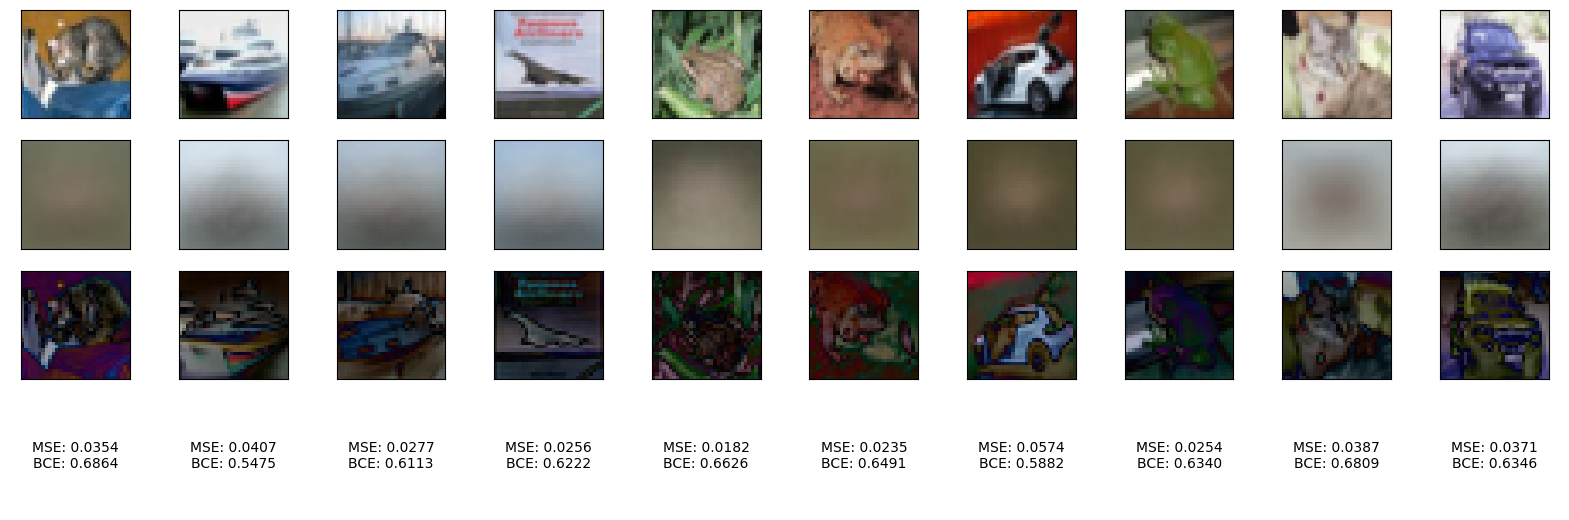

In [14]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test_vae[i].reshape(32,32,3)
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_test_pred[i].reshape(32,32,3)
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

In [15]:
def hyperparameter_tuning_strategy(cofig, x_train, x_test):
  intermediate_dim, latent_dim = config
  possible_combinations = list(itertools.product(intermediate_dim, latent_dim))
  print("*"*25)
  print(f"Possible No.of Combinations : {possible_combinations}")
  print("*"*25)
  hist = []
  for i in range(len(possible_combinations)):
    print("*"*25)
    print(f"Combination : {i+1}")
    print("*"*25)
    intermediate_dim, latent_dim = possible_combinations[i]
    # Hyperparameters
    batch_size = 32
    original_dim = 3072  # 32*32*3
    epochs = 25
    epsilon_std = 1.0

    # Encoder network
    x = Input(shape=(original_dim,), name='input')
    h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
    z_mean = Dense(latent_dim, name='mean')(h)
    z_log_var = Dense(latent_dim, name='log-variance')(h)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Sample from the latent distribution
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder network
    decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')
    decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # VAE model
    vae = Model(x, x_decoded_mean)

    # Loss function: reconstruction loss + KL divergence
    reconstruction_loss = binary_crossentropy(x, x_decoded_mean) * original_dim
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer=Adam())
    #Early Stopping with Patience as 5
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    file_path = 'best_model.h5'
    #Saving Best Model
    model_check = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    #Training the AutoEncoder Model
    x_train_vae = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test_vae = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    history = vae.fit(x_train_vae, x_train_vae, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test_vae, x_test_vae), callbacks=[early_stop, model_check], verbose=0)
    test_loss = vae.evaluate(x_test_vae, x_test_vae)
    hist.append(list((intermediate_dim, latent_dim, test_loss)))
    print(f"Combination : {i+1} -> {possible_combinations[i]}  test_mse : {test_loss}")
    print("*"*25)
    print("*"*25)
  return hist

In [16]:
config = [[128, 256], [2, 4]]

hist = hyperparameter_tuning_strategy(config, x_train, x_test)

*************************
Possible No.of Combinations : [(128, 2), (128, 4), (256, 2), (256, 4)]
*************************
*************************
Combination : 1
*************************

Epoch 1: val_loss improved from inf to 1965.11877, saving model to best_model.h5

Epoch 2: val_loss improved from 1965.11877 to 1961.11743, saving model to best_model.h5

Epoch 3: val_loss improved from 1961.11743 to 1960.14221, saving model to best_model.h5

Epoch 4: val_loss improved from 1960.14221 to 1959.43628, saving model to best_model.h5

Epoch 5: val_loss did not improve from 1959.43628

Epoch 6: val_loss improved from 1959.43628 to 1958.30371, saving model to best_model.h5

Epoch 7: val_loss did not improve from 1958.30371

Epoch 8: val_loss improved from 1958.30371 to 1957.87195, saving model to best_model.h5

Epoch 9: val_loss did not improve from 1957.87195

Epoch 10: val_loss improved from 1957.87195 to 1957.55493, saving model to best_model.h5

Epoch 11: val_loss improved from 1957.

In [17]:
hist = pd.DataFrame(hist, columns=["Intermediate Dimension", "Latent Dimension Space", "Test Loss"])
hist = hist.sort_values(by=["Test Loss"], ascending=True)
hist

,Intermediate Dimension,Latent Dimension Space,Test Loss
3,256,4,1912.474854
1,128,4,1913.034546
2,256,2,1949.791748
0,128,2,1953.869263


In [19]:
print("*"*25)
print(f"----Best Combination---- \n Learning Rate = {hist.iloc[0,0]}\n Latent Dimension Space = {hist.iloc[0,1]}\n")
print("*"*25)
print("*"*25)
before_mse = np.round(results, 4)
after_mse = np.round(hist.iloc[0, 2], 4)
print(f'Results Before Tunning:\n Test Loss MSE: {before_mse}\n')
print(f'Results After Tunning:\n Test Loss MSE: {after_mse}\n')
print(f'{np.round((before_mse-after_mse)*100/before_mse)}% Improvement')

*************************
----Best Combination---- 
 Learning Rate = 256
 Latent Dimension Space = 4

*************************
*************************
Results Before Tunning:
 Test Loss MSE: 1952.6909

Results After Tunning:
 Test Loss MSE: 1912.4749

2.0% Improvement


In [25]:
list(hist.iloc[0, :2])

[256.0, 4.0]

In [26]:
intermediate_dim, latent_dim = list(hist.iloc[0, :2])

In [27]:
# Hyperparameters
batch_size = 32
original_dim = 3072  # 32*32*3
latent_dim = int(latent_dim)
intermediate_dim = int(intermediate_dim)
epochs = 25
epsilon_std = 1.0

# Encoder network
x = Input(shape=(original_dim,), name='input')
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)
z_log_var = Dense(latent_dim, name='log-variance')(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Sample from the latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder network
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')
decoder_mean = Dense(original_dim, activation='sigmoid', name='decoder_mean')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae = Model(x, x_decoded_mean)

# Loss function: reconstruction loss + KL divergence
reconstruction_loss = binary_crossentropy(x, x_decoded_mean) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())
# vae.summary()

In [28]:
#Early Stopping with Patience as 5
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
file_path = 'best_model.h5'
#Saving Best Model
model_check = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#Training the AutoEncoder Model
x_train_vae = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_vae = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
history = vae.fit(x_train_vae, x_train_vae, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test_vae, x_test_vae), callbacks=[early_stop, model_check], verbose=0)


Epoch 1: val_loss improved from inf to 1924.23169, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1924.23169 to 1920.18909, saving model to best_model.h5

Epoch 3: val_loss improved from 1920.18909 to 1918.52380, saving model to best_model.h5

Epoch 4: val_loss did not improve from 1918.52380

Epoch 5: val_loss improved from 1918.52380 to 1915.50818, saving model to best_model.h5

Epoch 6: val_loss improved from 1915.50818 to 1914.85046, saving model to best_model.h5

Epoch 7: val_loss improved from 1914.85046 to 1914.68506, saving model to best_model.h5

Epoch 8: val_loss did not improve from 1914.68506

Epoch 9: val_loss improved from 1914.68506 to 1914.53430, saving model to best_model.h5

Epoch 10: val_loss improved from 1914.53430 to 1913.73022, saving model to best_model.h5

Epoch 11: val_loss did not improve from 1913.73022

Epoch 12: val_loss improved from 1913.73022 to 1913.21887, saving model to best_model.h5

Epoch 13: val_loss improved from 1913.21887 to 1912.58826, saving model to best_model.h5

Epoch 14: val_loss did not improve from 1

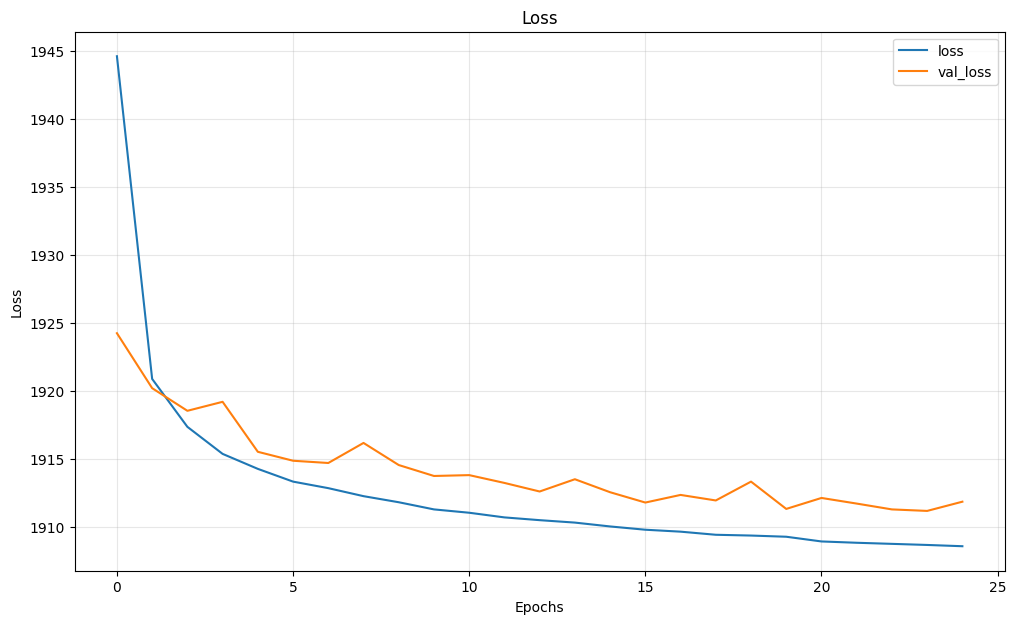

In [29]:
plt.figure(figsize=(12,7))

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [30]:
test_loss = vae.evaluate(x_test_vae, x_test_vae)

313/313 [==============================] - 1s 4ms/step - loss: 1911.9677


In [31]:
x_test_pred = vae.predict(x_test_vae)

313/313 [==============================] - 1s 3ms/step


In [32]:
mse_loss, bce_loss = calculate_reconstruction_losses(x_test_vae, x_test_pred)

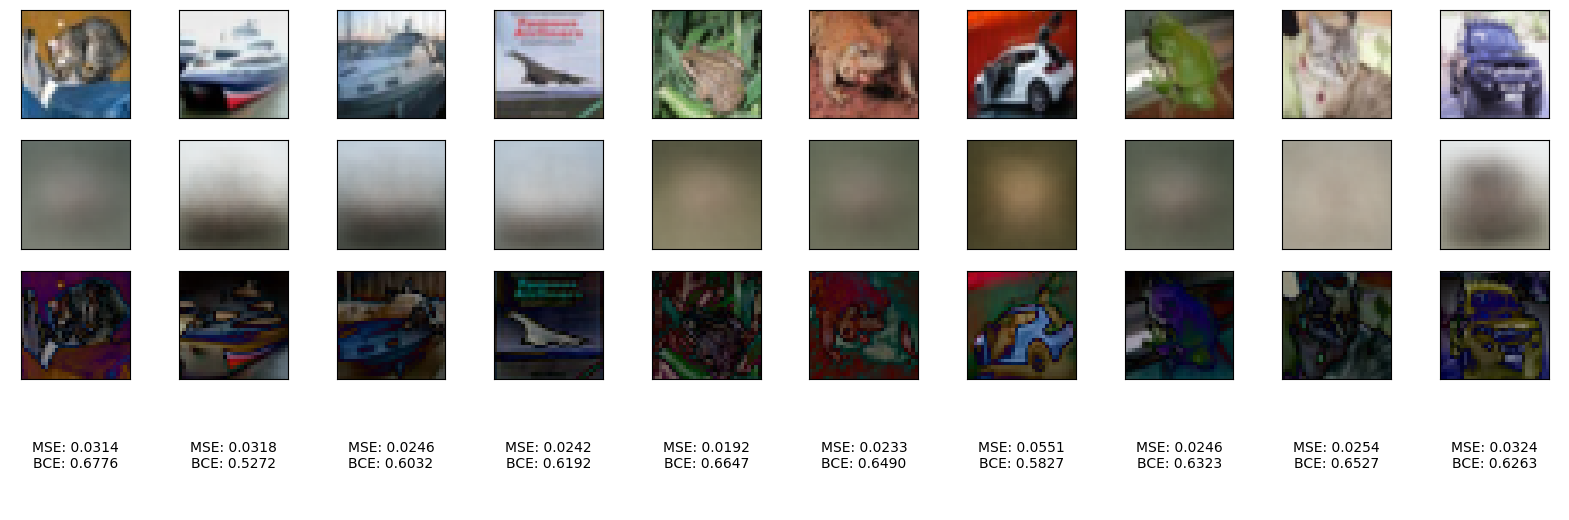

In [33]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 6 + 0.5))  # Adjust the figure size to accommodate three rows
for i in range(n):
    # Display original
    ax = plt.subplot(4, n, i + 1)
    original_img = x_test_vae[i].reshape(32,32,3)
    plt.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    reconstructed_img = x_test_pred[i].reshape(32,32,3)
    plt.imshow(reconstructed_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display difference
    ax = plt.subplot(4, n, i + 1 + n * 2)
    difference = np.abs(original_img - reconstructed_img)
    plt.imshow(difference)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Calculate losses
    mse_loss, bce_loss = calculate_reconstruction_losses(original_img, reconstructed_img)

    # Add captions with losses
    ax = plt.subplot(4, n, i + 1 + n * 3)
    plt.axis('off')
    loss_caption = f"MSE: {mse_loss:.4f}\nBCE: {bce_loss:.4f}"
    plt.text(0.5, 0.5, loss_caption, ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()